<a href="https://colab.research.google.com/github/amolaka/DS-3001---Voting-Project/blob/main/voting_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip3 install mapclassify

In [2]:
# Import libraries and packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import mapclassify
from mpl_toolkits.axes_grid1 import make_axes_locatable

GOTTA FIGURE OUT HOW TO GET THIS WORKING

In [3]:
# Import files
! git clone https://github.com/DS3001/project_voting
#gdf = gpd.read_file('VirginiaCounty_ClippedToShoreline.shx') # Load Virginia shapefile for maps
vdf = pd.read_csv('/content/project_voting/data/voting_VA.csv') # Load historical voting data
cdf = pd.read_csv('/content/project_voting/data/county_adjacencies.csv') # Load county adjacency data and population data

# Merge shapefile data and county adjacency data:
#gdf['FIPS_left'] = pd.to_numeric(gdf['STCOFIPS'])
#df = gdf.merge(cdf,left_on='FIPS_left',right_on='FIPS')  # merge county population and adjacency data into df
#del gdf, cdf

Cloning into 'project_voting'...
remote: Enumerating objects: 188, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 188 (delta 45), reused 96 (delta 41), pack-reused 81
Receiving objects: 100% (188/188), 91.77 MiB | 9.55 MiB/s, done.
Resolving deltas: 100% (70/70), done.
Updating files: 100% (92/92), done.


In [4]:
# Import VA data
va_data = pd.read_csv('/content/project_voting/data/voting_VA.csv')
va_data = va_data.drop("Unnamed: 0", axis = 1)
va_data.head()

year     state state_po county_name  county_fips        office  \
0  2000  VIRGINIA       VA    ACCOMACK        51001  US PRESIDENT   
1  2000  VIRGINIA       VA    ACCOMACK        51001  US PRESIDENT   
2  2000  VIRGINIA       VA    ACCOMACK        51001  US PRESIDENT   
3  2000  VIRGINIA       VA    ACCOMACK        51001  US PRESIDENT   
4  2000  VIRGINIA       VA   ALBEMARLE        51003  US PRESIDENT   

        candidate       party  candidatevotes  totalvotes   version   mode  
0         AL GORE    DEMOCRAT            5092       11925  20220315  TOTAL  
1  GEORGE W. BUSH  REPUBLICAN            6352       11925  20220315  TOTAL  
2     RALPH NADER       GREEN             220       11925  20220315  TOTAL  
3           OTHER       OTHER             261       11925  20220315  TOTAL  
4         AL GORE    DEMOCRAT           16255       36846  20220315  TOTAL

In [5]:
# Drop NAs
va_data = va_data.dropna()

<Axes: >

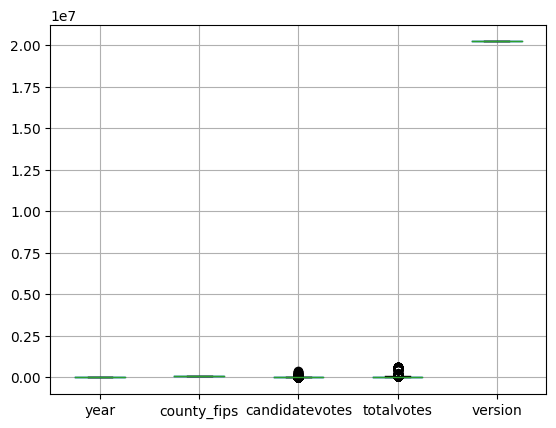

In [6]:
# Look at outliers
va_data.boxplot()

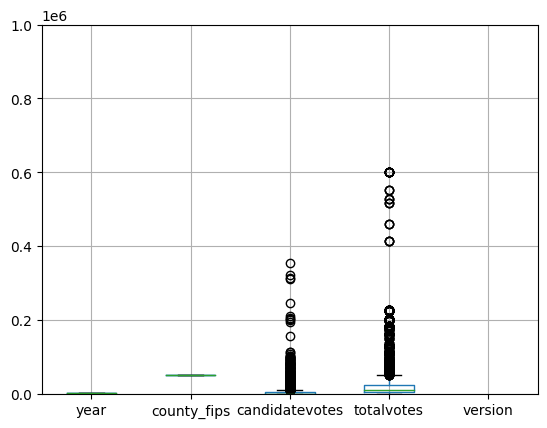

In [7]:
# Get a better view of outliers
va_data.boxplot()
plt.ylim(-1, 1000000)
plt.show()

In [8]:
# Log transformation
va_data['candidatevotes_log'] = np.log(va_data['candidatevotes'])
va_data['totalvotes_log'] = np.log(va_data['totalvotes'])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: >

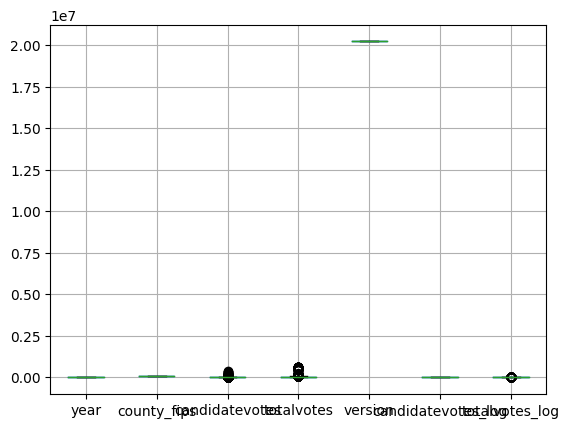

In [9]:
# View boxplots again
va_data.boxplot()

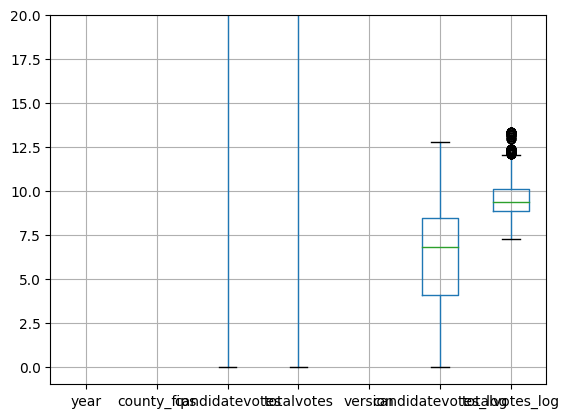

In [10]:
# Better view
va_data.boxplot()
plt.ylim(-1, 20)
plt.show()

# Much better!

In [11]:
# Look at the election votes for the years to determine best one for model
print(va_data['mode'].unique())
print(va_data['year'].unique())
modes_by_year = va_data.groupby('year')['mode'].unique()
print(modes_by_year)

# So only 2020 has all the different ways people voted, whereas the other years only have total
# 2020 is also the most recent with the same presidential candidates as this year, so use this

['TOTAL' 'ABSENTEE' 'ELECTION DAY' 'PROVISIONAL']
[2000 2004 2008 2012 2016 2020]
year
2000                                  [TOTAL]
2004                                  [TOTAL]
2008                                  [TOTAL]
2012                                  [TOTAL]
2016                                  [TOTAL]
2020    [ABSENTEE, ELECTION DAY, PROVISIONAL]
Name: mode, dtype: object


In [12]:
#va_data = va_data[va_data['year'] == 2020]
va_data.head()

year     state state_po county_name  county_fips        office  \
0  2000  VIRGINIA       VA    ACCOMACK        51001  US PRESIDENT   
1  2000  VIRGINIA       VA    ACCOMACK        51001  US PRESIDENT   
2  2000  VIRGINIA       VA    ACCOMACK        51001  US PRESIDENT   
3  2000  VIRGINIA       VA    ACCOMACK        51001  US PRESIDENT   
4  2000  VIRGINIA       VA   ALBEMARLE        51003  US PRESIDENT   

        candidate       party  candidatevotes  totalvotes   version   mode  \
0         AL GORE    DEMOCRAT            5092       11925  20220315  TOTAL   
1  GEORGE W. BUSH  REPUBLICAN            6352       11925  20220315  TOTAL   
2     RALPH NADER       GREEN             220       11925  20220315  TOTAL   
3           OTHER       OTHER             261       11925  20220315  TOTAL   
4         AL GORE    DEMOCRAT           16255       36846  20220315  TOTAL   

   candidatevotes_log  totalvotes_log  
0            8.535426        9.386392  
1            8.756525        9.386392  
2            5.393628        9.386392  
3            5.564520        9.386392  
4            9.696156       10.514502

In [13]:
va_data['party'].unique()

array(['DEMOCRAT', 'REPUBLICAN', 'GREEN', 'OTHER', 'LIBERTARIAN'],
      dtype=object)

In [14]:
county_votes = va_data.groupby(['year', 'state', 'county_fips', 'county_name', 'party'])['candidatevotes'].sum().unstack(fill_value=0)

# Aggregate votes for each party
democrat_votes = county_votes['DEMOCRAT'].reset_index(name='democrat_votes')
republican_votes = county_votes['REPUBLICAN'].reset_index(name='republican_votes')

# Merge Democrat and Republican votes
county_votes = democrat_votes.merge(republican_votes, on=['year', 'state', 'county_fips', 'county_name'], how='outer')

# Fill missing values with 0 (if a county doesn't have votes for one of the parties)
county_votes.fillna(0, inplace=True)

# Calculate total votes
county_votes['total_votes'] = county_votes['democrat_votes'] + county_votes['republican_votes']

county_votes

year     state  county_fips          county_name  democrat_votes  \
0    2000  VIRGINIA        51001             ACCOMACK            5092   
1    2000  VIRGINIA        51003            ALBEMARLE           16255   
2    2000  VIRGINIA        51005            ALLEGHANY            2214   
3    2000  VIRGINIA        51007               AMELIA            1754   
4    2000  VIRGINIA        51009              AMHERST            4812   
..    ...       ...          ...                  ...             ...   
798  2020  VIRGINIA        51800         SUFFOLK CITY           28676   
799  2020  VIRGINIA        51810  VIRGINIA BEACH CITY          117393   
800  2020  VIRGINIA        51820      WAYNESBORO CITY            4961   
801  2020  VIRGINIA        51830    WILLIAMSBURG CITY            4790   
802  2020  VIRGINIA        51840      WINCHESTER CITY            6610   

     republican_votes  total_votes  
0                6352        11444  
1               18291        34546  
2                2808         5022  
3                2947         4701  
4                6660        11472  
..                ...          ...  
798             20082        48758  
799            105087       222480  
800              5507        10468  
801              1963         6753  
802              5221        11831  

[803 rows x 7 columns]

In [15]:
county_votes.to_csv('county_votes_allyears.csv')

In [16]:
# Import county adjacencies data
county_adjacencies = pd.read_csv('/content/project_voting/data/county_adjacencies.csv')
county_adjacencies.head()

County  Population2022   FIPS  District                   N1  \
0        Accomack           33191  51001         2       Northumberland   
1       Albemarle          114534  51003         5  CharlottesvilleCity   
2  AlexandriaCity          155525  51510         8              Fairfax   
3       Alleghany           14835  51005         6                Craig   
4          Amelia           13455  51007         5         PrinceEdward   

           N2         N3             N4           N5        N6      N7  \
0   Lancaster  Middlesex        Mathews  Northampton       NaN     NaN   
1      Nelson    Augusta     Rockingham       Greene    Orange  Louisa   
2   Arlington        NaN            NaN          NaN       NaN     NaN   
3        Bath  Botetourt  CovingtonCity   Rockbridge       NaN     NaN   
4  Cumberland   Powhatan   Chesterfield    Dinwiddie  Nottoway     NaN   

         N8          N9     N10  N11  N12  
0       NaN         NaN     NaN  NaN  NaN  
1  Fluvanna  Buckingham  Nelson  NaN  NaN  
2       NaN         NaN     NaN  NaN  NaN  
3       NaN         NaN     NaN  NaN  NaN  
4       NaN         NaN     NaN  NaN  NaN

In [17]:
# Drop NAs
county_adjacencies = county_adjacencies.dropna()

<Axes: >

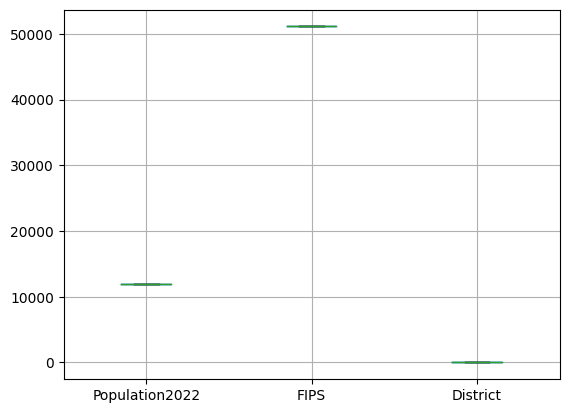

In [18]:
# Look at outliers
county_adjacencies.boxplot()
# Looks good!